# P300 Speller Dataset - BCI Competition III

In [1]:
import numpy as np
from scipy.io import loadmat
import os

# Directory containing the .mat files
data_dir = 'BCI_Comp_III_Wads_2004'

def load_p300_mat(mat_path):
    """
    Load a P300 Speller .mat file and return the relevant NumPy arrays.
    This keeps the natural structure: 
    - Signal: (epochs, samples, channels)
    - Flashing / StimulusCode / StimulusType: (epochs, samples)
    """

    data = loadmat(mat_path)

    # Extract variables and convert to float64 / int
    Signal       = data['Signal'].astype(np.float64)          # EEG data
    Flashing     = data['Flashing'].astype(np.int16)          # 0/1 flash indicator
    StimulusCode = data['StimulusCode'].astype(np.int16)      # 1–12 code
    StimulusType = data['StimulusType'].astype(np.int16) if 'StimulusType' in data else None
    TargetChar   = data['TargetChar'] if 'TargetChar' in data else None

    return {
        "Signal": Signal,                   # (epochs, samples, channels)
        "Flashing": Flashing,               # (epochs, samples)
        "StimulusCode": StimulusCode,       # (epochs, samples)
        "StimulusType": StimulusType,       # (epochs, samples) or None
        "TargetChar": TargetChar            # (epochs,) or None
    }


# Load all 4 .mat files
mat_files = {
    'A_train': os.path.join(data_dir, 'Subject_A_Train.mat'),
    'A_test':  os.path.join(data_dir, 'Subject_A_Test.mat'),
    'B_train': os.path.join(data_dir, 'Subject_B_Train.mat'),
    'B_test':  os.path.join(data_dir, 'Subject_B_Test.mat')
}

all_data = {}

print("Loading P300 datasets...\n")
for key, path in mat_files.items():
    print(f"Loading {key} from {path}")
    all_data[key] = load_p300_mat(path)

Loading P300 datasets...

Loading A_train from BCI_Comp_III_Wads_2004/Subject_A_Train.mat
Loading A_test from BCI_Comp_III_Wads_2004/Subject_A_Test.mat
Loading B_train from BCI_Comp_III_Wads_2004/Subject_B_Train.mat
Loading B_test from BCI_Comp_III_Wads_2004/Subject_B_Test.mat


In [2]:
"""
P300 Event Dataset Variable Reference:

- Signal: 
    EEG data, shape = (epochs, samples, channels)

- Flashing: 
    1 if a row/column is currently being intensified (i.e., flashed), 
    0 otherwise

- StimulusCode: 
    0: matrix blank (no row/column intensified)
    1-6: one of the six columns is being intensified
         (1 is left-most column, 6 is right-most)
    7-12: one of the six rows is being intensified
          (7 is upper-most row, 12 is bottom-most)

- StimulusType: 
    0: intensified row/column does NOT contain the target character
       OR nothing is being intensified
    1: intensified row/column DOES contain the desired character
    (This provides label information for classifier training.)

- TargetChar: 
    The correct character (as a label) for each character epoch (only present in training data).
"""

A_signal       = np.array(all_data["A_train"]["Signal"])
A_flashing     = np.array(all_data["A_train"]["Flashing"])
A_stim_code    = np.array(all_data["A_train"]["StimulusCode"])
A_stim_type    = np.array(all_data["A_train"]["StimulusType"])
A_target_char  = np.array(all_data["A_train"]["TargetChar"])

print(A_signal.shape)
print(A_flashing.shape)
print(A_stim_code.shape)
print(A_stim_type.shape)
print(A_target_char.shape)




(85, 7794, 64)
(85, 7794)
(85, 7794)
(85, 7794)
(1,)


- In each epoch (one target letter), the person focuses on a single intended character in the 6x6 matrix.
- A sequence is one full pass where each of the 6 rows and 6 columns (12 total) is flashed exactly once, in random order.
- During that epoch, there are 15 such sequences, so each of the 12 rows/columns is flashed 15 times, giving 15 * 12 = 180 flashes for that target character.
- To identify the intended letter, we detect which row and which column produce P300 responses and take their intersection in the matrix.

- Per epoch, we therefore have 15 sequences * 12 flashes = 180 flashes total.
- In each sequence, 2 of the 12 stimuli (one row and one column) are targets, so 15 * 2 = 30 target flashes and 180 - 30 = 150 non-target flashes.

- Per subject:
  - 85 * 30 = 2550 target flashes (P300s)
  - 85 * 150 = 12750 non-target flashes

- Across both subjects (training sets), this gives about 5100 target and 25500 non-target flashes.

- Total: 5,100 / 30,600 ≈ 16–17% positives -> about 1:5 target:non‑target

Target segments: (2537, 192, 64)
Non-target segments: (12678, 192, 64)


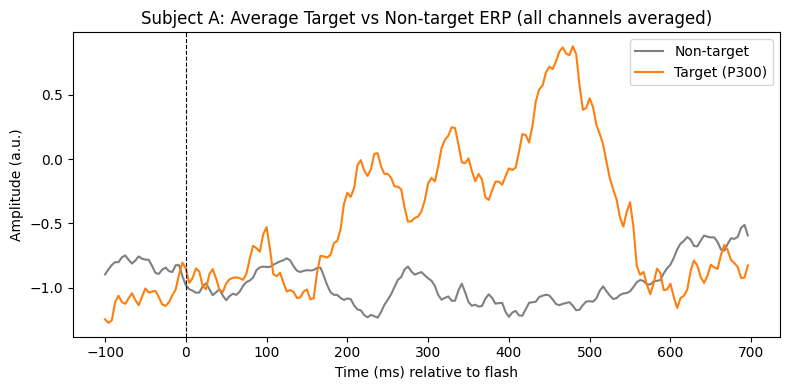

In [ ]:
#Graph mean amplitude for P300 vs non-P300 after stimulus

import matplotlib.pyplot as plt

fs = 240  # sampling rate (Hz)
pre_time = 0.1   # 100 ms before flash
post_time = 0.7  # 700 ms after flash

def extract_flash_locked_epochs(signal, flashing, stim_type, fs=240, t_pre=0.1, t_post=0.7):
    """Extract flash-locked EEG segments and split into target vs non-target.

    signal: (epochs, samples, channels)
    flashing: (epochs, samples) 0/1
    stim_type: (epochs, samples) 0/1 (1 = target flash)
    """
    n_epochs, n_samples, n_ch = signal.shape
    pre = int(t_pre * fs)
    post = int(t_post * fs)

    target_segments = []
    nontarget_segments = []

    # For each epoch
    for ep in range(n_epochs):
        # Find all onset times for flashes in this epoch. Flash onsets: 0 -> 1 transitions in Flashing
        # An onset is the first sample of a flash event, where the flashing signal goes from 0 to 1.
        # Syntax explanation:
        #    flashing[ep, 1:] gives flash values from index 1 onward;
        #    flashing[ep, :-1] gives all except the last sample.
        # By comparing these, we detect the exact sample where the transition from 0 to 1 occurs.
        onsets = np.where((flashing[ep, 1:] == 1) & (flashing[ep, :-1] == 0))[0] + 1
        for idx in onsets:
            if idx - pre < 0 or idx + post > n_samples:
                continue
            seg = signal[ep, idx - pre : idx + post, :]  # (time, channels)
            if stim_type[ep, idx] == 1:
                target_segments.append(seg)
            else:
                nontarget_segments.append(seg)

    return np.array(target_segments), np.array(nontarget_segments)


A_tgt_segs, A_nontgt_segs = extract_flash_locked_epochs(A_signal, A_flashing, A_stim_type,
                                                        fs=fs, t_pre=pre_time, t_post=post_time)

print("Target segments:", A_tgt_segs.shape)
print("Non-target segments:", A_nontgt_segs.shape)

# Average across trials and channels to get a 1D ERP
A_tgt_mean = A_tgt_segs.mean(axis=(0, 2))
A_nontgt_mean = A_nontgt_segs.mean(axis=(0, 2))

# Time axis in ms
n_time = A_tgt_mean.shape[0]
time_ms = np.linspace(-pre_time, post_time, n_time, endpoint=False) * 1000

plt.figure(figsize=(8, 4))
plt.plot(time_ms, A_nontgt_mean, label="Non-target", color="gray")
plt.plot(time_ms, A_tgt_mean, label="Target (P300)", color="C1")
plt.axvline(0, color="k", linestyle="--", linewidth=0.8)
plt.xlabel("Time (ms) relative to flash")
plt.ylabel("Amplitude (a.u.)")
plt.title("Subject A: Average Target vs Non-target ERP (all channels averaged)")
plt.legend()
plt.tight_layout()
plt.show()


In Line with current research indicating Time window for P300 peaks: roughly 250–500 ms post‐stimulus onset 

Source: https://pmc.ncbi.nlm.nih.gov/articles/PMC2715154/?utm_source=chatgpt.com

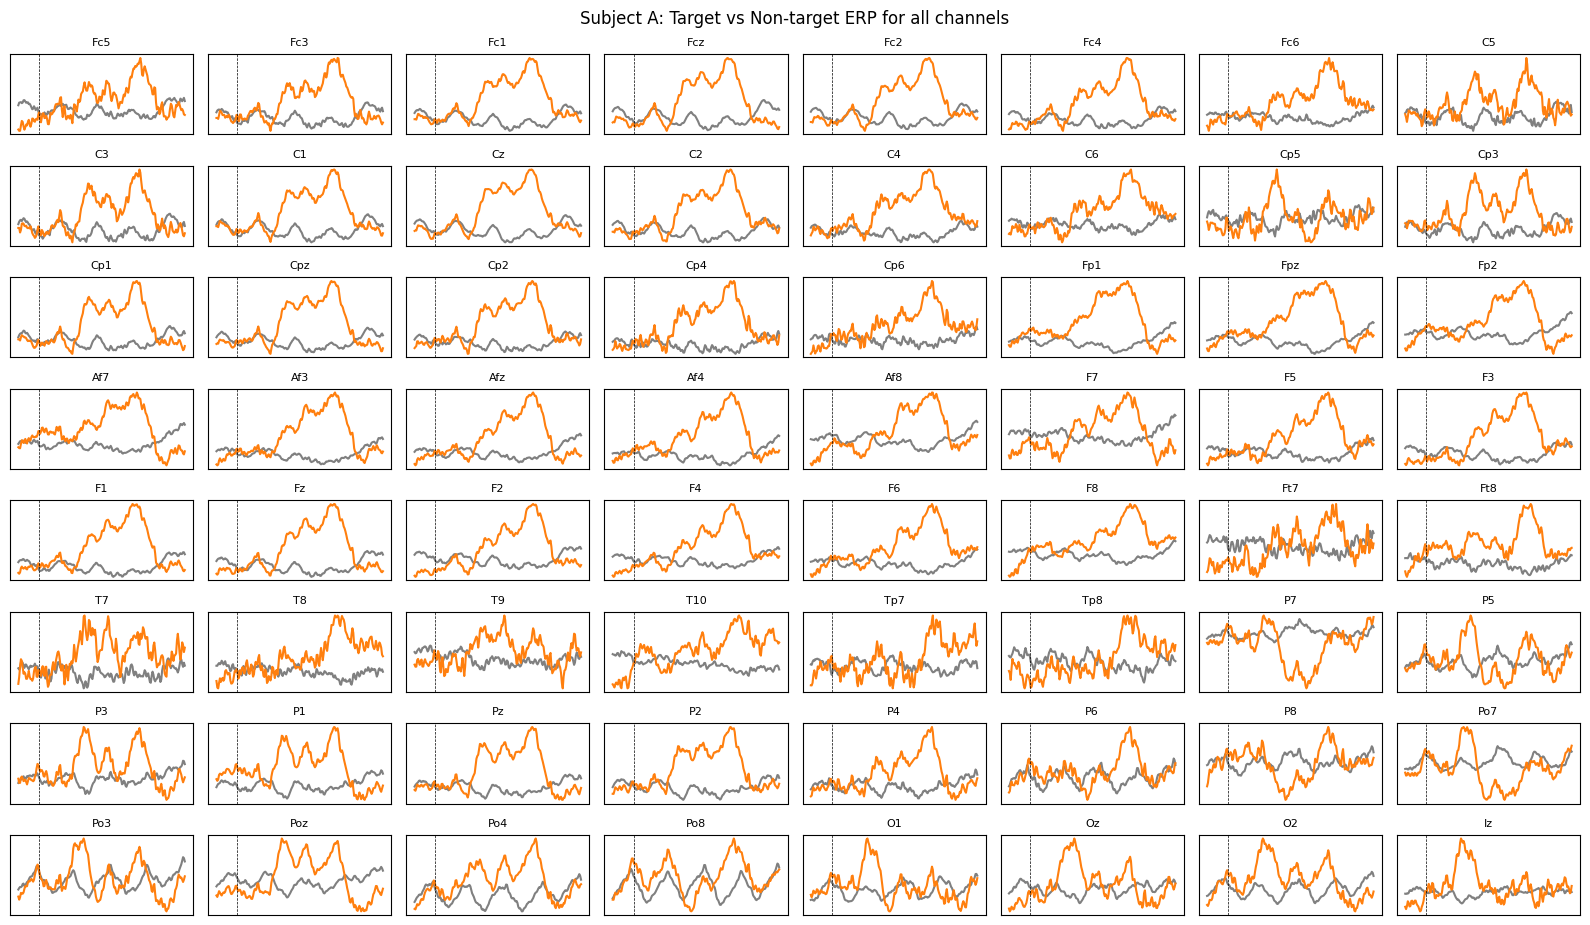

In [4]:
# Plot P300 vs non-P300 for all 64 channels in a grid

# Average across trials only, keep time x channels
A_tgt_mean_tc = A_tgt_segs.mean(axis=0)      # (time, channels)
A_nontgt_mean_tc = A_nontgt_segs.mean(axis=0)

n_time = A_tgt_mean_tc.shape[0]
time_ms = np.linspace(-pre_time, post_time, n_time, endpoint=False) * 1000

# Load channel labels from eloc64.txt (4th column)
eloc_path = os.path.join(data_dir, "eloc64.txt")
eloc = np.genfromtxt(eloc_path, dtype=None, encoding="utf-8")
chan_labels = [row[3].strip(".") for row in eloc]

rows, cols = 8, 8
plt.figure(figsize=(16, 10))
for ch in range(64):
    plt.subplot(rows, cols, ch + 1)
    plt.plot(time_ms, A_nontgt_mean_tc[:, ch], color="gray")
    plt.plot(time_ms, A_tgt_mean_tc[:, ch], color="C1")
    plt.axvline(0, color="k", linestyle="--", linewidth=0.5)
    plt.title(chan_labels[ch], fontsize=8)
    plt.xticks([])
    plt.yticks([])

plt.suptitle("Subject A: Target vs Non-target ERP for all channels", y=0.92)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


In [ ]:
# Find channels where target ERP is most positive vs non-target in 250–500 ms

# Average across trials -> time x channels
A_tgt_mean_tc = A_tgt_segs.mean(axis=0)      # (time, channels)
A_nontgt_mean_tc = A_nontgt_segs.mean(axis=0)

n_time = A_tgt_mean_tc.shape[0]
time_ms = np.linspace(-pre_time, post_time, n_time, endpoint=False) * 1000

# Define the P300 window (250–500 ms after flash)
p300_mask = (time_ms >= 250) & (time_ms <= 500)

# Compute target - non-target difference in that window
diff_tc = A_tgt_mean_tc - A_nontgt_mean_tc           # (time, channels)
p300_score = diff_tc[p300_mask, :].mean(axis=0)      # one score per channel

#Get channel labels from eloc64.txt
eloc_path = os.path.join(data_dir, "eloc64.txt")
eloc = np.genfromtxt(eloc_path, dtype=None, encoding="utf-8")
chan_labels = [row[3].strip(".") for row in eloc]

# Sort channels by score (largest positive separation first)
sorted_idx = np.argsort(p300_score)[::-1]

print("Top 10 P300 channels (target more positive than non-target, 250–500 ms):")
for rank in range(10):
    ch = sorted_idx[rank]
    print(f"{rank+1:2d}. {chan_labels[ch]:<4}  score = {p300_score[ch]:.4f}")

Top 10 P300 channels (target more positive than non-target, 250–500 ms):
 1. Cz    score = 3.0422
 2. Fc1   score = 2.6241
 3. Cpz   score = 2.5097
 4. C1    score = 2.4422
 5. Fcz   score = 2.4368
 6. C2    score = 2.3898
 7. Fc2   score = 2.2885
 8. Fp1   score = 2.1778
 9. F1    score = 2.1731
10. Fz    score = 2.1384


### In line with current research. Cz, Fc1, Cpz are top channels showing strongest signs of ERP.

In [9]:
print("PCA + Logistic Regression on flash segments, using top 3 P300 channels (200-600 ms)")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

# Choose top 3 channels by name (from earlier ranking)
# Here we use Cz, Fc1, Cpz
selected_chan_names = ["Cz", "Fc1", "Cpz"]

# Map names to indices using chan_labels (loaded earlier from eloc64.txt)
chan_name_to_idx = {name: i for i, name in enumerate(chan_labels)}
sel_idx = [chan_name_to_idx[name] for name in selected_chan_names]
print("Using channel indices:", sel_idx, "for", selected_chan_names)

# Define P300 time window for features (200–600 ms)
window_mask = (time_ms >= 200) & (time_ms <= 600)
window_idx = np.where(window_mask)[0]
print("Window samples:", window_idx[0], "to", window_idx[-1], "(", time_ms[window_idx[0]], "ms to", time_ms[window_idx[-1]], "ms )")

# Build feature matrices for target and non-target flashes
# Shapes: A_tgt_segs -> (n_tgt, time, channels)
X_tgt = A_tgt_segs[:, window_idx][:, :, sel_idx].reshape(A_tgt_segs.shape[0], -1)
X_non = A_nontgt_segs[:, window_idx][:, :, sel_idx].reshape(A_nontgt_segs.shape[0], -1)

y_tgt = np.ones(X_tgt.shape[0], dtype=int)
y_non = np.zeros(X_non.shape[0], dtype=int)

# Combine
X = np.vstack([X_tgt, X_non])
y = np.concatenate([y_tgt, y_non])

print("Feature matrix shape:", X.shape, "(flashes x flattened time*channels)")
print("Class balance (targets, non-targets):", y_tgt.sum(), ",", y_non.shape[0])

# Train/test split. MUST BE DONE BEFORE PCA. (this splits by flashes, not by character epochs)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
# PCA + Logistic Regression pipeline
n_components = 20  # number of principal components to keep (decided to keep it small)

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=n_components, random_state=42)),
    ("logreg", LogisticRegression(max_iter=1000, class_weight="balanced", solver="lbfgs")),
])

clf.fit(X_train, y_train)

# Evaluation
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("Classification report (flash-level):")
print(classification_report(y_test, y_pred, digits=3))

auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {auc:.3f}")


PCA + Logistic Regression on flash segments, using top 3 P300 channels (200-600 ms)
Using channel indices: [10, 2, 17] for ['Cz', 'Fc1', 'Cpz']
Window samples: 73 to 168 ( 204.16666666666663 ms to 600.0 ms )
Feature matrix shape: (15215, 288) (flashes x flattened time*channels)
Class balance (targets, non-targets): 2537 , 12678
Classification report (flash-level):
              precision    recall  f1-score   support

           0      0.883     0.587     0.705      2536
           1      0.228     0.609     0.332       507

    accuracy                          0.591      3043
   macro avg      0.555     0.598     0.518      3043
weighted avg      0.774     0.591     0.643      3043

ROC AUC: 0.620


In [14]:
print("Running PCA + Logistic Regression using ONLY top 3 channels after stimulus (0–600 ms)")

# Use top 3 channels by name
selected_chan_names = ["Cz", "Fc1", "Cpz"]
chan_name_to_idx = {name: i for i, name in enumerate(chan_labels)}
sel_idx = [chan_name_to_idx[name] for name in selected_chan_names]
print("Using channel indices:", sel_idx, "for", selected_chan_names)

# Time window: 0–600 ms after flash (post-stimulus only)
window_mask = (time_ms >= 0) & (time_ms <= 600)
window_idx = np.where(window_mask)[0]
print("Window samples:", window_idx[0], "to", window_idx[-1], "(", time_ms[window_idx[0]], "ms to", time_ms[window_idx[-1]], "ms )")

# Build feature matrices (flatten time × 3 channels)
X_tgt = A_tgt_segs[:, window_idx][:, :, sel_idx].reshape(A_tgt_segs.shape[0], -1)
X_non = A_nontgt_segs[:, window_idx][:, :, sel_idx].reshape(A_nontgt_segs.shape[0], -1)

y_tgt = np.ones(X_tgt.shape[0], dtype=int)
y_non = np.zeros(X_non.shape[0], dtype=int)

X = np.vstack([X_tgt, X_non])
y = np.concatenate([y_tgt, y_non])

print("Feature matrix shape:", X.shape)
print("Class balance (targets, non-targets):", y_tgt.sum(), ",", y_non.shape[0])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# PCA + Logistic Regression
n_components = 20
clf_3ch = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=n_components, random_state=42)),
    ("logreg", LogisticRegression(max_iter=1000, class_weight="balanced", solver="lbfgs")),
])

clf_3ch.fit(X_train, y_train)

# Evaluation
y_pred = clf_3ch.predict(X_test)
y_proba = clf_3ch.predict_proba(X_test)[:, 1]

print("Classification report (flash-level, 3 channels, 0–600 ms):")
print(classification_report(y_test, y_pred, digits=3))

auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {auc:.3f}")


Running PCA + Logistic Regression using ONLY top 3 channels after stimulus (0–600 ms)
Using channel indices: [10, 2, 17] for ['Cz', 'Fc1', 'Cpz']
Window samples: 24 to 168 ( 0.0 ms to 600.0 ms )
Feature matrix shape: (15215, 435)
Class balance (targets, non-targets): 2537 , 12678
Classification report (flash-level, 3 channels, 0–600 ms):
              precision    recall  f1-score   support

           0      0.884     0.590     0.707      2536
           1      0.229     0.611     0.334       507

    accuracy                          0.593      3043
   macro avg      0.557     0.600     0.520      3043
weighted avg      0.775     0.593     0.645      3043

ROC AUC: 0.641
